In [119]:
# Imports
import time
import numpy as np
from six import next
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import scipy
import pickle
import codecs
import seaborn as sns
from collections import Counter
import re
import csv

## 1) Load ratings dataset

In [2]:
df = pd.read_csv(r"/scratch/user/achadha7/IRProject/MovieLens/ml-latest-small/ratings.csv", sep=',', engine='python')
df["rating"] = df["rating"].astype(np.float32)

In [3]:
df.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


## 2) Creating user and movie indices

In [4]:
user_mapping = {}
movie_mapping = {}
index = 0
for x in list(df["userId"].unique()):
    user_mapping[x] = index
    index += 1
index = 0
for x in list(df["movieId"].unique()):
    movie_mapping[x] = index
    index += 1

In [5]:
df["userId"] = df["userId"].map(user_mapping)
df["movieId"] = df["movieId"].map(movie_mapping)
df.head(5)

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179
2,0,2,3.0,1260759182
3,0,3,2.0,1260759185
4,0,4,4.0,1260759205


In [113]:
print("Number of users:")
len(user_mapping)

Number of users


671

In [114]:
print("Number of movies:")
len(movie_mapping)

Number of movies:


9066

### Visualizing distribution of ratings over movies

In [121]:
i = 0
dict_genres = {}
with open('/scratch/user/achadha7/IRProject/MovieLens/ml-latest-small/ratings.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        i = i+1
        if(i==1):
            continue

        if row[2] not in dict_genres:
            dict_genres[row[2]] = 1
        else:
            dict_genres[row[2]] = dict_genres[row[2]] + 1

print(dict_genres)
print("Total: ", i)
print(len(dict_genres.keys()))

{'2.5': 4449, '3.0': 20064, '2.0': 7271, '4.0': 28750, '3.5': 10538, '1.0': 3326, '5.0': 15095, '4.5': 7723, '1.5': 1687, '0.5': 1101}
Total:  100005
10


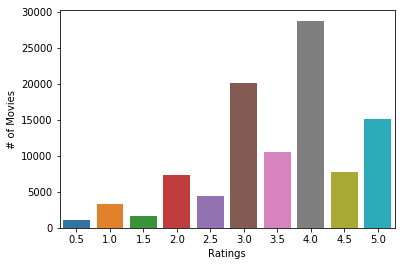

In [123]:
x = []
y = []
for d in dict_genres:
    x.append(d)
    y.append(dict_genres[d])

ax = sns.barplot(x, y)
ax.set(xlabel ='Ratings', ylabel ='# of Movies')
plt.show()

## 3) Load Movies dataset

In [8]:
movies = pd.read_csv(r"/scratch/user/achadha7/IRProject/MovieLens/ml-latest-small/movies.csv", sep=',', engine='python')
movies["movieId"]= movies["movieId"].map(movie_mapping)
movies = movies.set_index('movieId')
movies["genres"]= movies["genres"].map(lambda x: x.replace('|', ' ').lower())

In [9]:
movies.head(5)

,title,genres
movieId,,
417.0,Toy Story (1995),adventure animation children comedy fantasy
650.0,Jumanji (1995),adventure children fantasy
319.0,Grumpier Old Men (1995),comedy romance
2084.0,Waiting to Exhale (1995),comedy drama romance
651.0,Father of the Bride Part II (1995),comedy


## 4) Create Movie Features:

In [21]:
movie_content = []
index_set = set(movies.index)
for i in range(len(movie_mapping)):
    if i in index_set:
        movie_content.append(movies.loc[[i]].iloc[0]["genres"])
    else:
        movie_content.append('')

In [31]:
vectorizer = CountVectorizer(binary = True)
movie_feature_matrix = vectorizer.fit_transform(movie_content)

List of all Genres present in the dataset

In [79]:
genre_to_indices_map = vectorizer.vocabulary_
indices_to_genre_map = {v: k for k, v in genre_to_indices_map.items()}

genre_map_sorted = {}
for key in sorted(indices_to_genre_map.keys()):
    genre_map_sorted[key] = indices_to_genre_map[key]
genres_list = list(genre_map_sorted.values())

In [80]:
genres_movie_count = np.sum(movie_feature_matrix, axis=0).reshape(-1,).tolist()[0]

In [94]:
genre_movie_dict = dict(zip(genres_list, genres_movie_count))

In [98]:
genres_movie_count

['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'fi',
 'film',
 'genres',
 'horror',
 'imax',
 'listed',
 'musical',
 'mystery',
 'no',
 'noir',
 'romance',
 'sci',
 'thriller',
 'war',
 'western']

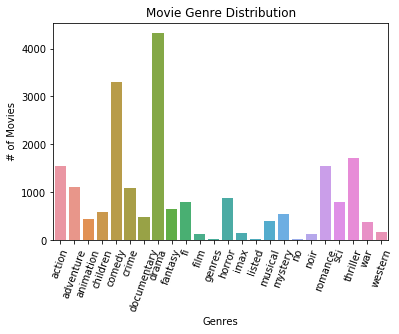

In [112]:
import matplotlib.pyplot as plt
ax = sns.barplot(genres_list, genres_movie_count)
plt.xticks(rotation=70)
plt.title("Movie Genre Distribution")
ax.set(xlabel='Genres', ylabel='# of Movies')
plt.show()

## 5) Reading tags provided by user to movies

In [115]:
users = pd.read_csv(r"/scratch/user/achadha7/IRProject/MovieLens/ml-latest-small/tags.csv", sep=',', engine='python')
users["userId"]= users["userId"].map(user_mapping)
users = users.set_index('userId')
users.head()

,movieId,tag,timestamp
userId,,,
14,339,sandra 'boring' bullock,1138537770
14,1955,dentist,1193435061
14,7478,Cambodia,1170560997
14,32892,Russian,1170626366
14,34162,forgettable,1141391765


In [116]:
user_content = []
index_set = set(users.index)
for i in range(len(user_mapping)):
    if i in index_set:
        user_content.append(' '.join(list(users.loc[[i]]["tag"])))
    else:
        user_content.append('')
user_content = vectorizer.fit_transform(user_content)
user_content = user_content.astype(np.float32)

In [118]:
user_content.shape

(671, 764)